# ChernoffPy: Option Pricing via Chernoff Approximations
Pricing European and Barrier options by solving the heat equation
with operator semigroup methods.

This demo shows the core workflow in about 5 minutes.

In [1]:
# pip install chernoffpy  # when package is published on PyPI
import sys
from pathlib import Path

# Make local package importable when notebook runs from examples/
repo_root = Path.cwd().resolve().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

from chernoffpy import CrankNicolson, BackwardEuler
from chernoffpy.finance import (
    EuropeanPricer, BarrierPricer,
    MarketParams, BarrierParams,
    compute_greeks, bs_exact_price,
)

import numpy as np
import matplotlib.pyplot as plt

## 2. European Option: Basic Example
We price a vanilla European call and compare it with the analytical Black-Scholes value.

In [2]:
market = MarketParams(S=100, K=105, T=1.0, r=0.05, sigma=0.20)
pricer = EuropeanPricer(CrankNicolson())

result = pricer.price(market, n_steps=50, option_type="call")
bs = bs_exact_price(market, "call")

print(f"Chernoff price: {result.price:.4f}")
print(f"Black-Scholes:  {bs:.4f}")
print(f"Error:          {abs(result.price - bs)/bs:.4%}")

Chernoff price: 8.0200
Black-Scholes:  8.0214
Error:          0.0172%


The numbers should be very close. 
This means we recover the classical price, but through Chernoff semigroup approximation.

## 3. Accuracy Certificate (USP)
Each price comes with an internal error decomposition.

In [3]:
cert = result.certificate

print(f"Chernoff error: {cert.chernoff_error:.2e}")
print(f"Domain error:   {cert.domain_error:.2e}")
print(f"Total error:    {cert.abs_error:.2e}")
print(f"BS exact:       {cert.bs_price:.4f}")

Chernoff error: 1.35e-04
Domain error:   1.51e-03
Total error:    1.38e-03
BS exact:       8.0214


In other words: every run includes not only a price, but also transparent quality metrics.

## 4. Greeks
Compute standard sensitivities from the same model.

In [4]:
greeks = compute_greeks(pricer, market, n_steps=50, option_type="call")

print(f"Delta: {greeks.delta:.4f}")
print(f"Gamma: {greeks.gamma:.6f}")
print(f"Vega:  {greeks.vega:.4f}")
print(f"Theta: {greeks.theta:.4f}")
print(f"Rho:   {greeks.rho:.4f}")

Delta: 0.5423
Gamma: 0.019828
Vega:  39.6812
Theta: -6.2783
Rho:   46.2022


## 5. Convergence Plot
Compare convergence speed for Crank-Nicolson vs Backward Euler.

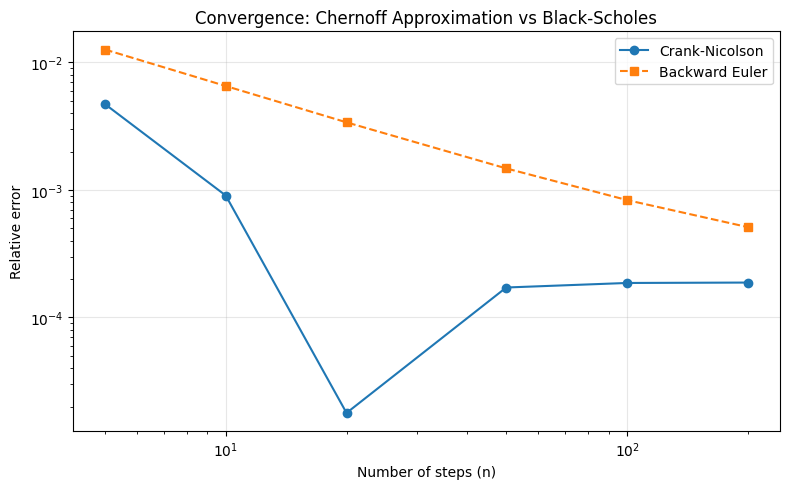

In [5]:
ns = [5, 10, 20, 50, 100, 200]
errors_cn = []
errors_be = []

pricer_cn = EuropeanPricer(CrankNicolson())
pricer_be = EuropeanPricer(BackwardEuler())

for n in ns:
    r_cn = pricer_cn.price(market, n_steps=n, option_type="call")
    r_be = pricer_be.price(market, n_steps=n, option_type="call")
    errors_cn.append(abs(r_cn.price - bs) / bs)
    errors_be.append(abs(r_be.price - bs) / bs)

plt.figure(figsize=(8, 5))
plt.loglog(ns, errors_cn, 'o-', label='Crank-Nicolson')
plt.loglog(ns, errors_be, 's--', label='Backward Euler')
plt.xlabel('Number of steps (n)')
plt.ylabel('Relative error')
plt.title('Convergence: Chernoff Approximation vs Black-Scholes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(repo_root / 'examples' / 'convergence.png', dpi=150)
plt.show()

You should see faster decay for Crank-Nicolson, consistent with higher-order behavior.

## 6. Barrier Option Example
Down-and-out call is cheaper than vanilla because it gets canceled if price falls below barrier.

In [6]:
barrier_params = BarrierParams(barrier=90, barrier_type="down_and_out")
b_pricer = BarrierPricer(CrankNicolson())

market_barrier = MarketParams(S=100, K=100, T=1.0, r=0.05, sigma=0.20)
b_result = b_pricer.price(market_barrier, barrier_params, n_steps=50, option_type="call")

print(f"Down-and-Out Call: {b_result.price:.4f}")
print(f"Vanilla Call:      {b_result.vanilla_price:.4f}")
print(f"Knock-in (parity): {b_result.vanilla_price - b_result.knockout_price:.4f}")

Down-and-Out Call: 8.8661
Vanilla Call:      10.4490
Knock-in (parity): 1.5829


## 7. All 8 Barrier Variants
Quick table for all combinations: direction x in/out x call/put.

In [7]:
types = [
    ("down_and_out", 90, "call"), ("down_and_in", 90, "call"),
    ("up_and_out", 120, "call"),  ("up_and_in", 120, "call"),
    ("down_and_out", 90, "put"),  ("down_and_in", 90, "put"),
    ("up_and_out", 120, "put"),   ("up_and_in", 120, "put"),
]

print(f"{'Type':<20} {'Option':<6} {'Price':>10} {'Vanilla':>10}")
print('-' * 52)
for bt, B, ot in types:
    bp = BarrierParams(barrier=B, barrier_type=bt)
    r = b_pricer.price(market_barrier, bp, n_steps=50, option_type=ot)
    print(f"{bt:<20} {ot:<6} {r.price:>10.4f} {r.vanilla_price:>10.4f}")

Type                 Option      Price    Vanilla
----------------------------------------------------
down_and_out         call       8.8661    10.4490
down_and_in          call       1.5829    10.4490
up_and_out           call       1.2127    10.4490
up_and_in            call       9.2364    10.4490


down_and_out         put        0.1602     5.5720
down_and_in          put        5.4118     5.5720
up_and_out           put        5.3719     5.5720
up_and_in            put        0.2001     5.5720
